In [1]:
# Loan Default Prediction
# Sbonelo Mntungwa

In [2]:
# feature engineering libaries
import pandas as pd
import numpy as np
import random as rnd
import math
import datetime as dt

In [3]:
# visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [4]:
# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier


In [5]:
# getting data
train_demo = pd.read_csv('traindemographics.csv')
test_demo = pd.read_csv('testdemographics.csv')
train_prev = pd.read_csv('trainprevloans.csv')
test_prev = pd.read_csv('testprevloans.csv')
train_perf = pd.read_csv('trainperf.csv')
test_perf = pd.read_csv('testperf.csv')

In [6]:
# feature engineering train/test_demo

In [7]:
test_demo.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858f305c8dd672015c93b1db645db4,1976-08-28 00:00:00.000000,Savings,5.296628,7.593965,Heritage Bank,NaN,Permanent,NaN
1,8a858f085a477386015a47fb049e49ca,1978-06-23 00:00:00.000000,Savings,3.294513,6.596602,UBA,NaN,Permanent,NaN
2,8a858e6f5cd5e874015cd6f5634c39ad,1984-04-04 00:00:00.000000,Savings,8.501912,7.729364,First Bank,NaN,Permanent,NaN
3,8a858e9d5bfd7037015bfdab79f61305,1983-05-28 00:00:00.000000,Savings,3.318904,6.681595,UBA,NaN,Permanent,NaN
4,8a858fde56eb02280156eb6dafc128ac,1982-03-29 00:00:00.000000,Savings,6.354624,4.949031,First Bank,NaN,Self-Employed,NaN


In [8]:
# dropping [dateofbirth] since we are unable to detect current age of customers
# dropping approveddate and creationdate since the values have incorrect date  formats in the testperf data 
# determining current age of customers is determined by dateofbirth and creationdate

In [9]:
train_perf = train_perf.drop(['approveddate','creationdate'], axis=1)
test_perf = test_perf.drop(['approveddate','creationdate'], axis=1)
train_demo = train_demo.drop(['birthdate'], axis=1)
test_demo = test_demo.drop(['birthdate'], axis=1)

In [10]:
# investigate bank_account_type
train_demo['bank_account_type'].value_counts()

Savings    3425
Other       865
Current      56
Name: bank_account_type, dtype: int64

In [11]:
# combine current and other
combine_demo = [train_demo, test_demo]
for dataset in combine_demo:
    dataset['bank_account_type'] = dataset['bank_account_type'].replace({'Savings': 1, 'Other': 0, 'Current': 0})

In [12]:
# determine point of center for area
longitude_mean = train_demo['longitude_gps'].mean()
latitude_mean = train_demo['latitude_gps'].mean()


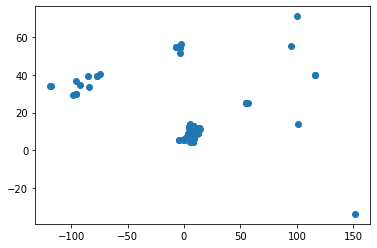

In [13]:
plt.scatter(train_demo['longitude_gps'], train_demo['latitude_gps'])

In [14]:
from sklearn.cluster import KMeans

In [15]:
# determine centroids of locations 
df = df = pd.DataFrame({
    'x': train_demo['latitude_gps'],
    'y': train_demo['longitude_gps']
})
kmeans = KMeans(n_clusters=4)
kmeans.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [16]:
centers = kmeans.cluster_centers_

In [17]:
# function to determine the rearest coordinates from the centroid
def find_nearest_center(x,y):
    smallest_distance = 999999999
    ind = -1
    counter = 0
    for center in centers:
        dist = (center[0]-x)**2 + (center[1]-y)**2
        dist = math.sqrt(dist)
        if(dist< smallest_distance):
            smallest_distance = dist
            ind = counter
        counter = counter + 1
    return ind

In [18]:
# assigning coordinates with region
reg = []
reg_test = []
for i,j in zip(train_demo['latitude_gps'],train_demo['longitude_gps']):
    reg.append(find_nearest_center(i,j))
for i,j in zip(test_demo['latitude_gps'],test_demo['longitude_gps']):
    reg_test.append(find_nearest_center(i,j))
train_demo['region'] = reg
test_demo['region'] = reg_test
test_demo['region'].value_counts()

0    1089
3     393
1       5
Name: region, dtype: int64

In [19]:
# merging uncommon regions
combine_demo = [train_demo,test_demo]
for dataset in combine_demo:
    dataset['region'] = dataset['region'].replace({2: 1, 3: 1})

In [20]:
# drop latitude and longitde
train_demo = train_demo.drop(['longitude_gps', 'latitude_gps'], axis=1)
test_demo = test_demo.drop(['longitude_gps', 'latitude_gps'], axis=1)

In [21]:
train_demo.head()

,customerid,bank_account_type,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,region
0,8a858e135cb22031015cbafc76964ebd,1,GT Bank,NaN,NaN,NaN,0
1,8a858e275c7ea5ec015c82482d7c3996,1,Sterling Bank,NaN,Permanent,NaN,0
2,8a858e5b5bd99460015bdc95cd485634,1,Fidelity Bank,NaN,NaN,NaN,0
3,8a858efd5ca70688015cabd1f1e94b55,1,GT Bank,NaN,Permanent,NaN,0
4,8a858e785acd3412015acd48f4920d04,1,GT Bank,NaN,Permanent,NaN,1


In [22]:
# investigate bank
train_demo['bank_name_clients'].value_counts()

GT Bank               1598
First Bank             590
Access Bank            432
UBA                    353
Zenith Bank            301
Diamond Bank           282
EcoBank                150
Stanbic IBTC           145
FCMB                   121
Fidelity Bank          103
Skye Bank              102
Sterling Bank           55
Wema Bank               28
Union Bank              23
Heritage Bank           22
Keystone Bank           19
Standard Chartered      15
Unity Bank               7
Name: bank_name_clients, dtype: int64

In [23]:
# bank_branch_clients (dropping as entries too low)
train_demo = train_demo.drop(['bank_branch_clients'], axis=1)
test_demo = test_demo.drop(['bank_branch_clients'], axis=1)

In [24]:
# employment_status_clients
train_demo['employment_status_clients'].value_counts()

Permanent        3146
Self-Employed     348
Student           142
Unemployed         57
Retired             4
Contract            1
Name: employment_status_clients, dtype: int64

In [25]:
#fill empty entries with unknown
train_demo['employment_status_clients']= train_demo['employment_status_clients'].fillna("Unknown")
test_demo['employment_status_clients']= test_demo['employment_status_clients'].fillna("Unknown")

In [26]:
# mask employment
employment_map = {'Permanent': 0, 'Self-Employed':1, 'Student':2, 'Unemployed':3, 'Retired':4,'Contract':5, 'Unknown':6 }
combine_demo = [train_demo, test_demo]
for dataset in combine_demo:
    dataset['employment_status_clients'] = dataset['employment_status_clients'].replace(employment_map)

In [27]:
# level_of_education_clients
train_demo['level_of_education_clients'].value_counts()

Graduate         420
Secondary         89
Post-Graduate     68
Primary           10
Name: level_of_education_clients, dtype: int64

In [28]:
# fill empty entries with unknown
train_demo['level_of_education_clients']= train_demo['level_of_education_clients'].fillna("Unknown")
test_demo['level_of_education_clients']= test_demo['level_of_education_clients'].fillna("Unknown")

In [29]:
# mask education
education_map = {'Graduate': 0, 'Secondary':1, 'Post-Graduate':2, 'Primary':3, 'Unknown':4 }
combine_demo = [train_demo, test_demo]
for dataset in combine_demo:
    dataset['level_of_education_clients'] = dataset['level_of_education_clients'].replace(education_map)

In [30]:
train_demo.head()

,customerid,bank_account_type,bank_name_clients,employment_status_clients,level_of_education_clients,region
0,8a858e135cb22031015cbafc76964ebd,1,GT Bank,6,4,0
1,8a858e275c7ea5ec015c82482d7c3996,1,Sterling Bank,0,4,0
2,8a858e5b5bd99460015bdc95cd485634,1,Fidelity Bank,6,4,0
3,8a858efd5ca70688015cabd1f1e94b55,1,GT Bank,0,4,0
4,8a858e785acd3412015acd48f4920d04,1,GT Bank,0,4,1


In [31]:
train_demo_1 = train_demo.drop(['customerid'], axis=1)
train_demo_1 = train_demo.drop(['bank_name_clients'], axis=1)

In [32]:
#train_demo_1 = pd.get_dummies(train_demo_1)

In [33]:
train_demo_1.head()

,customerid,bank_account_type,employment_status_clients,level_of_education_clients,region
0,8a858e135cb22031015cbafc76964ebd,1,6,4,0
1,8a858e275c7ea5ec015c82482d7c3996,1,0,4,0
2,8a858e5b5bd99460015bdc95cd485634,1,6,4,0
3,8a858efd5ca70688015cabd1f1e94b55,1,0,4,0
4,8a858e785acd3412015acd48f4920d04,1,0,4,1


In [34]:
test_demo_1 = test_demo.drop(['customerid'], axis=1)
test_demo_1 = test_demo.drop(['bank_name_clients'], axis=1)
#test_demo_1 = pd.get_dummies(test_demo_1)

In [35]:
train_demo_1['customerid'] = train_demo['customerid']
test_demo_1['customerid'] = test_demo['customerid']

In [36]:
train_demo = train_demo_1
test_demo = test_demo_1

In [37]:
train_demo.head()

,customerid,bank_account_type,employment_status_clients,level_of_education_clients,region
0,8a858e135cb22031015cbafc76964ebd,1,6,4,0
1,8a858e275c7ea5ec015c82482d7c3996,1,0,4,0
2,8a858e5b5bd99460015bdc95cd485634,1,6,4,0
3,8a858efd5ca70688015cabd1f1e94b55,1,0,4,0
4,8a858e785acd3412015acd48f4920d04,1,0,4,1


In [38]:
# working on testprevloans
test_prev.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a858899538ddb8e015390510b321f08,301621635,3,2016-05-17 10:37:00.000000,2016-05-17 09:36:55.000000,10000.0,13000.0,30,2016-06-17 00:04:15.000000,NaN,2016-06-16 00:00:00.000000,2016-06-16 15:44:08.000000
1,8a858959537a097401537a4e316e25f7,301810201,5,2017-02-04 21:28:59.000000,2017-02-04 20:28:52.000000,30000.0,36800.0,60,2017-03-02 16:22:58.000000,NaN,2017-03-06 00:00:00.000000,2017-03-02 16:07:47.000000
2,8a858959537a097401537a4e316e25f7,301831255,6,2017-03-04 10:28:22.000000,2017-03-04 09:28:16.000000,30000.0,34400.0,30,2017-04-02 00:44:24.000000,NaN,2017-04-03 00:00:00.000000,2017-04-01 21:29:46.000000
3,8a8589c253ace09b0153af6ba58f1f31,301627292,3,2016-06-02 14:27:14.000000,2016-06-02 13:27:08.000000,10000.0,13000.0,30,2016-07-04 11:34:04.000000,NaN,2016-07-04 00:00:00.000000,2016-07-04 11:19:01.000000
4,8a8589c253ace09b0153af6ba58f1f31,301621095,2,2016-05-16 09:13:12.000000,2016-05-16 08:13:04.000000,10000.0,11500.0,15,2016-06-02 00:02:58.000000,NaN,2016-05-31 00:00:00.000000,2016-06-01 15:22:34.000000


In [39]:
# investigate loan number
train_prev['loannumber'].value_counts()

1     4344
2     2969
3     2300
4     1860
5     1535
6     1288
7     1036
8      817
9      637
10     446
11     333
12     223
13     146
14      96
15      54
16      33
17      19
18      16
19      10
20       8
21       7
22       2
23       1
24       1
25       1
26       1
Name: loannumber, dtype: int64

In [40]:
# do not understand functionality of loan number
train_prev = train_prev.drop(['loannumber'], axis=1)
test_prev = test_prev.drop(['loannumber'], axis=1)

In [41]:
train_prev.head()

,customerid,systemloanid,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000
3,8a8588f35438fe12015444567666018e,301861541,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,NaN,2017-04-24 00:00:00.000000,2017-04-24 00:48:43.000000
4,8a85890754145ace015429211b513e16,301941754,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,NaN,2017-07-03 00:00:00.000000,2017-07-14 21:08:35.000000


In [42]:
train_perf = train_perf.drop(['loannumber'], axis=1)
test_perf = test_perf.drop(['loannumber'], axis=1)

In [43]:
# converting to datetime
combine_prev = [train_prev,test_prev]
for dataset in combine_prev:
    dataset['approveddate'] = pd.to_datetime(dataset['approveddate']) 
    dataset['creationdate'] = pd.to_datetime(dataset['creationdate'])
    dataset['closeddate'] = pd.to_datetime(dataset['closeddate'])
    dataset['firstduedate'] = pd.to_datetime(dataset['firstduedate'])
    dataset['firstrepaiddate'] = pd.to_datetime(dataset['firstrepaiddate'])

In [44]:
# create date - approve date

combine_prev = [train_prev,test_prev]
for dataset in combine_prev:
    dataset['approval_length'] = dataset['approveddate'] - dataset['creationdate'] 

In [45]:
# close date - approve date

combine_prev = [train_prev,test_prev]
for dataset in combine_prev:
    dataset['loan_length'] = dataset['closeddate'] - dataset['approveddate'] 

In [46]:
# first repaid date - approve date
combine_prev = [train_prev,test_prev]
for dataset in combine_prev:
    dataset['first_pay_length'] = dataset['firstrepaiddate'] - dataset['approveddate'] 


In [47]:
train_prev.head()

,customerid,systemloanid,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate,approval_length,loan_length,first_pay_length
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2016-08-15 18:22:40,2016-08-15 17:22:32,10000.0,13000.0,30,2016-09-01 16:06:48,NaN,2016-09-14,2016-09-01 15:51:43,01:00:08,16 days 21:44:08,16 days 21:29:03
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,2017-04-28 18:39:07,2017-04-28 17:38:53,10000.0,13000.0,30,2017-05-28 14:44:49,NaN,2017-05-30,2017-05-26 00:00:00,01:00:14,29 days 20:05:42,27 days 05:20:53
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,2017-03-05 10:56:25,2017-03-05 09:56:19,20000.0,23800.0,30,2017-04-26 22:18:56,NaN,2017-04-04,2017-04-26 22:03:47,01:00:06,52 days 11:22:31,52 days 11:07:22
3,8a8588f35438fe12015444567666018e,301861541,2017-04-09 18:25:55,2017-04-09 17:25:42,10000.0,11500.0,15,2017-04-24 01:35:52,NaN,2017-04-24,2017-04-24 00:48:43,01:00:13,14 days 07:09:57,14 days 06:22:48
4,8a85890754145ace015429211b513e16,301941754,2017-06-17 09:29:57,2017-06-17 08:29:50,10000.0,11500.0,15,2017-07-14 21:18:43,NaN,2017-07-03,2017-07-14 21:08:35,01:00:07,27 days 11:48:46,27 days 11:38:38


In [48]:
# drop dates
train_prev = train_prev.drop(['approveddate', 'creationdate','closeddate','firstduedate','firstrepaiddate'], axis=1)
test_prev = test_prev.drop(['approveddate', 'creationdate','closeddate','firstduedate','firstrepaiddate'], axis=1)

In [49]:
train_prev.head()

,customerid,systemloanid,loanamount,totaldue,termdays,referredby,approval_length,loan_length,first_pay_length
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,10000.0,13000.0,30,NaN,01:00:08,16 days 21:44:08,16 days 21:29:03
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,10000.0,13000.0,30,NaN,01:00:14,29 days 20:05:42,27 days 05:20:53
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,20000.0,23800.0,30,NaN,01:00:06,52 days 11:22:31,52 days 11:07:22
3,8a8588f35438fe12015444567666018e,301861541,10000.0,11500.0,15,NaN,01:00:13,14 days 07:09:57,14 days 06:22:48
4,8a85890754145ace015429211b513e16,301941754,10000.0,11500.0,15,NaN,01:00:07,27 days 11:48:46,27 days 11:38:38


In [50]:
# correlation between loan amount and total due
train_prev[['loanamount','totaldue']].corr()

,loanamount,totaldue
loanamount,1.000000,0.995142
totaldue,0.995142,1.000000


In [51]:
# drop feature
train_perf = train_perf.drop(['totaldue'], axis=1)
test_perf = test_perf.drop(['totaldue'], axis=1)
train_prev = train_prev.drop(['totaldue'], axis=1)
test_prev = test_prev.drop(['totaldue'], axis=1)

In [52]:
# investigate loan numb amount
train_prev['loanamount'].value_counts()

10000.0    10529
20000.0     3524
30000.0     2452
40000.0      867
15000.0      394
50000.0      106
25000.0      100
5000.0        95
8000.0        38
35000.0       27
6000.0        19
7000.0        11
9000.0         9
60000.0        5
4000.0         5
3000.0         2
Name: loanamount, dtype: int64

In [53]:
# mask loan amount
low_loan = [3000,4000,5000,6000,7000,8000]
med_loan = [9000,10000,15000,20000,25000]
high_loan = [30000,35000,40000,45000,50000]
combine_prev = [train_prev, test_prev]
for dataset in combine_prev:
    dataset['loanamount'] = dataset['loanamount'].replace(low_loan,0)
    dataset['loanamount'] = dataset['loanamount'].replace(med_loan,1)
    dataset['loanamount'] = dataset['loanamount'].replace(high_loan,2)

In [54]:
# mask loan amount
low_loan = [3000,4000,5000,6000,7000,8000]
med_loan = [9000,10000,15000,20000,25000]
high_loan = [30000,35000,40000,45000,50000]
combine_perf = [train_perf, test_perf]
for dataset in combine_perf:
    dataset['loanamount'] = dataset['loanamount'].replace(low_loan,0)
    dataset['loanamount'] = dataset['loanamount'].replace(med_loan,1)
    dataset['loanamount'] = dataset['loanamount'].replace(high_loan,2)

In [56]:
#  drop referred by
train_prev = train_prev.drop(['referredby'], axis=1)
test_prev = test_prev.drop(['referredby'], axis=1)
train_perf = train_perf.drop(['referredby'], axis=1)
test_perf = test_perf.drop(['referredby'], axis=1)

In [57]:
train_prev.head()

,customerid,systemloanid,loanamount,termdays,approval_length,loan_length,first_pay_length
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,1.0,30,01:00:08,16 days 21:44:08,16 days 21:29:03
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,1.0,30,01:00:14,29 days 20:05:42,27 days 05:20:53
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,1.0,30,01:00:06,52 days 11:22:31,52 days 11:07:22
3,8a8588f35438fe12015444567666018e,301861541,1.0,15,01:00:13,14 days 07:09:57,14 days 06:22:48
4,8a85890754145ace015429211b513e16,301941754,1.0,15,01:00:07,27 days 11:48:46,27 days 11:38:38


In [58]:
# map term days
combine_prev = [train_prev,test_prev]
for dataset in combine_prev:
    dataset['termdays'] = dataset['termdays'].replace({15: 0, 30: 1, 60: 2, 90:3})

In [59]:
# map term days
combine_perf = [train_perf,test_perf]
for dataset in combine_perf:
    dataset['termdays'] = dataset['termdays'].replace({15: 0, 30: 1, 60: 2, 90:3})

In [60]:
train_prev.head()

,customerid,systemloanid,loanamount,termdays,approval_length,loan_length,first_pay_length
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,1.0,1,01:00:08,16 days 21:44:08,16 days 21:29:03
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,1.0,1,01:00:14,29 days 20:05:42,27 days 05:20:53
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,1.0,1,01:00:06,52 days 11:22:31,52 days 11:07:22
3,8a8588f35438fe12015444567666018e,301861541,1.0,0,01:00:13,14 days 07:09:57,14 days 06:22:48
4,8a85890754145ace015429211b513e16,301941754,1.0,0,01:00:07,27 days 11:48:46,27 days 11:38:38


In [61]:
combine_prev = [train_prev,test_prev]
for dataset in combine_prev:
    dataset['approval_length'] = pd.to_datetime(dataset['approval_length']).dt.hour

C:\Users\Banks\Anaconda3\lib\site-packages\pandas\util\_decorators.py:208: FutureWarning: Passing timedelta64-dtype data is deprecated, will raise a TypeError in a future version
  return func(*args, **kwargs)


In [62]:
train_prev['approval_length'].value_counts()

1     18054
2        40
3        20
4        10
11        6
9         6
8         6
5         6
12        5
6         5
10        4
7         4
14        3
22        2
17        2
16        2
19        2
23        2
13        2
21        1
15        1
Name: approval_length, dtype: int64

In [63]:
# extract day format
combine_prev = [train_prev,test_prev]
for dataset in combine_prev:
    dataset['loan_length'] = pd.to_datetime(dataset['loan_length']).dt.day
    dataset['first_pay_length'] = pd.to_datetime(dataset['first_pay_length']).dt.day

C:\Users\Banks\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Passing timedelta64-dtype data is deprecated, will raise a TypeError in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Banks\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Passing timedelta64-dtype data is deprecated, will raise a TypeError in a future version
  after removing the cwd from sys.path.


In [64]:
train_prev.head()

,customerid,systemloanid,loanamount,termdays,approval_length,loan_length,first_pay_length
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,1.0,1,1,17,17
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,1.0,1,1,30,28
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,1.0,1,1,22,22
3,8a8588f35438fe12015444567666018e,301861541,1.0,0,1,15,15
4,8a85890754145ace015429211b513e16,301941754,1.0,0,1,28,28


In [65]:
train_perf.head()

,customerid,systemloanid,loanamount,termdays,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,2.0,1,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,1.0,1,Good
2,8a8588f35438fe12015444567666018e,301966580,1.0,0,Good
3,8a85890754145ace015429211b513e16,301999343,1.0,0,Good
4,8a858970548359cc0154883481981866,301962360,2.0,1,Good


In [66]:
# masking good_bad_flag
train_perf['good_bad_flag'] = train_perf['good_bad_flag'].replace({'Good': 1, 'Bad': 0})

In [67]:
train_demo.head()

,customerid,bank_account_type,employment_status_clients,level_of_education_clients,region
0,8a858e135cb22031015cbafc76964ebd,1,6,4,0
1,8a858e275c7ea5ec015c82482d7c3996,1,0,4,0
2,8a858e5b5bd99460015bdc95cd485634,1,6,4,0
3,8a858efd5ca70688015cabd1f1e94b55,1,0,4,0
4,8a858e785acd3412015acd48f4920d04,1,0,4,1


In [68]:
train_perf.head()

,customerid,systemloanid,loanamount,termdays,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,2.0,1,1
1,8a85886e54beabf90154c0a29ae757c0,301965204,1.0,1,1
2,8a8588f35438fe12015444567666018e,301966580,1.0,0,1
3,8a85890754145ace015429211b513e16,301999343,1.0,0,1
4,8a858970548359cc0154883481981866,301962360,2.0,1,1


In [69]:
train_prev.head()

,customerid,systemloanid,loanamount,termdays,approval_length,loan_length,first_pay_length
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,1.0,1,1,17,17
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,1.0,1,1,30,28
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,1.0,1,1,22,22
3,8a8588f35438fe12015444567666018e,301861541,1.0,0,1,15,15
4,8a85890754145ace015429211b513e16,301941754,1.0,0,1,28,28


In [70]:
# merge records
train_prev_demo = pd.merge(train_demo, train_prev, how = 'inner', on = 'customerid')
test_prev_demo = pd.merge(test_demo, test_prev, how = 'inner', on = 'customerid')
train = pd.merge(train_prev_demo, train_perf, how = 'inner', on = 'customerid')
test = pd.merge(test_prev_demo, test_perf, how = 'inner', on = 'customerid')

In [71]:
train.head()

,customerid,bank_account_type,employment_status_clients,level_of_education_clients,region,systemloanid_x,loanamount_x,termdays_x,approval_length,loan_length,first_pay_length,systemloanid_y,loanamount_y,termdays_y,good_bad_flag
0,8a858e135cb22031015cbafc76964ebd,1,6,4,0,301943951,1.0,0,1,16,16,301964962,1.0,1,1
1,8a858e275c7ea5ec015c82482d7c3996,1,0,4,0,301929966,1.0,1,1,2,2,301972172,1.0,1,0
2,8a858e5b5bd99460015bdc95cd485634,1,6,4,0,301931228,1.0,1,1,2,2,301976271,1.0,1,1
3,8a858e5b5bd99460015bdc95cd485634,1,6,4,0,301895253,1.0,0,1,20,20,301976271,1.0,1,1
4,8a858e5b5bd99460015bdc95cd485634,1,6,4,0,301919784,1.0,0,1,12,12,301976271,1.0,1,1


In [72]:
# drop id
train = train.drop(['systemloanid_x', 'systemloanid_y','customerid'], axis=1)
test = test.drop(['systemloanid_x', 'systemloanid_y','customerid'], axis=1)


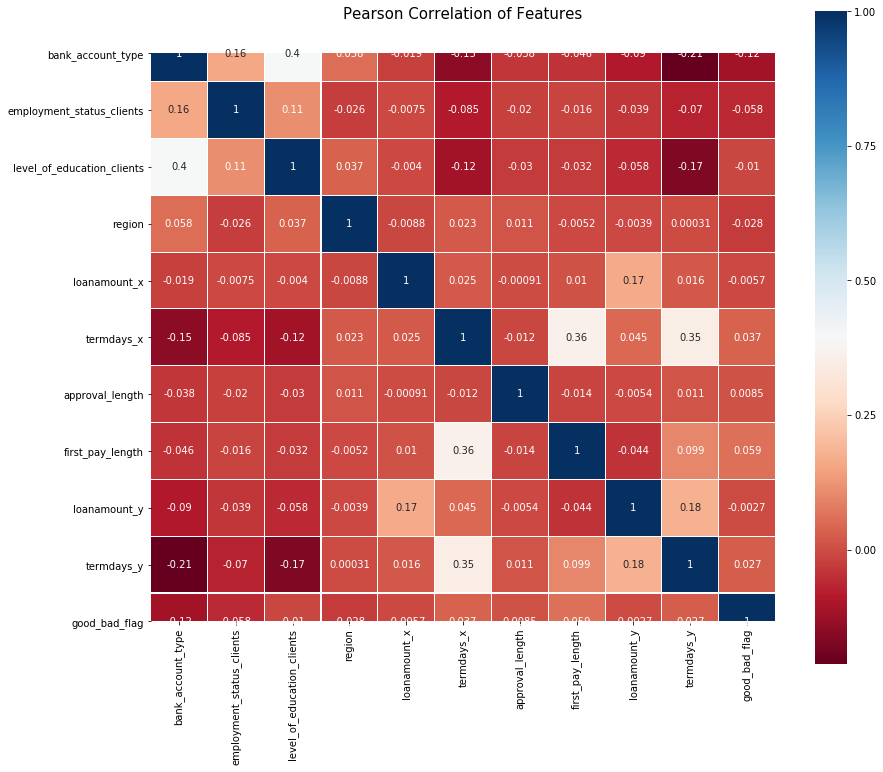

In [77]:
# correlating features
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [ ]:
# 94% correlation between when the customer first pays the loan and when the customer actually pays the loan 
# meaning the first pay length can be dropped

In [76]:
# drop loan_length
train = train.drop(['loan_length'], axis=1)
test = test.drop(['loan_length'], axis=1)

In [78]:
# setting x and y values
X_train = train.drop("good_bad_flag", axis=1)
Y_train = train["good_bad_flag"]
X_test  = test
X_train.shape, Y_train.shape, X_test.shape

((13693, 10), (13693,), (1605, 10))

In [79]:
# implement logistic regression
log = LogisticRegression()
log.fit(X_train, Y_train)
Y_pred = log.predict(X_test)
acc_log = round(log.score(X_train, Y_train) * 100, 2)
acc_log

C:\Users\Banks\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Banks\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


81.54

In [80]:
# implement support vector machine
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

C:\Users\Banks\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


81.71

In [81]:
# implement k nearest neighbour
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

81.76

In [82]:
# implement random forest
random_forest = RandomForestClassifier(n_estimators=10)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

87.29

In [83]:
# implement naive bayes
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

78.53

In [84]:
# implement support vector machine
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

C:\Users\Banks\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


81.71

In [85]:
# implement random forest
random_forest = RandomForestClassifier(n_estimators=10)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

87.17

In [90]:
# generate output
test_copy = pd.read_csv('testperf.csv')
test['customerid'] = test_copy['customerid']
submission = pd.DataFrame({
        "customerID": test["customerid"],
        "Good_Bad_flag": Y_pred
    })

In [91]:
# export to csv and submit
submission.to_csv('result.csv', index=False)

In [95]:
test_perf.shape

(1450, 4)

In [99]:
train.head()

,bank_account_type,employment_status_clients,level_of_education_clients,region,loanamount_x,termdays_x,approval_length,first_pay_length,loanamount_y,termdays_y,good_bad_flag
0,1,6,4,0,1.0,0,1,16,1.0,1,1
1,1,0,4,0,1.0,1,1,2,1.0,1,0
2,1,6,4,0,1.0,1,1,2,1.0,1,1
3,1,6,4,0,1.0,0,1,20,1.0,1,1
4,1,6,4,0,1.0,0,1,12,1.0,1,1


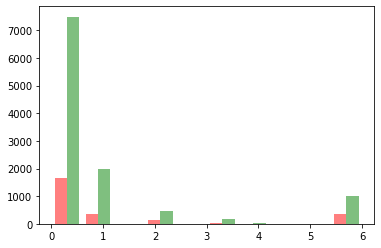

In [113]:
# employment status vs good/bad flag
plt.hist([[a for a, s in zip(train['employment_status_clients'], train['good_bad_flag']) if s==0], 
          [a for a, s in zip(train['employment_status_clients'],train['good_bad_flag']) if s==1]], 
         color=['r','g'], alpha=0.5, bins=10)
plt.show()

{'Permanent': 0, 'Self-Employed':1, 'Student':2, 'Unemployed':3, 'Retired':4,'Contract':5, 'Unknown':6 }
majority of the loans requested by the permanent employees. There is an element of high risk/high reward as majority of the bad loans are from the permanent.

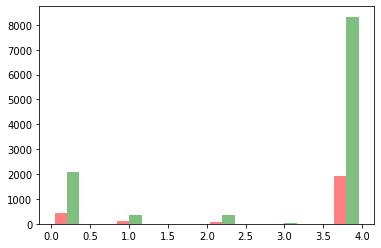

In [115]:
# education status vs good/bad flag
plt.hist([[a for a, s in zip(train['level_of_education_clients'], train['good_bad_flag']) if s==0], 
          [a for a, s in zip(train['level_of_education_clients'],train['good_bad_flag']) if s==1]], 
         color=['r','g'], alpha=0.5, bins=10)
plt.show()

{'Graduate': 0, 'Secondary':1, 'Post-Graduate':2, 'Primary':3, 'Unknown':4 }
this could mean a lot of customers that never went to school rely more on loans and do provide high risk.
Due to graduates paying for student loans or just starting out work there is a high request on loans. As a result careful investigations need to be done to evaluate the employement status on these students

Gender feature would play an important role as men and women spend money differently
One can make assumptions as women in Africa are breadwinners and have to request more loans to provide to the families
Another assumption is that men are generally financially irresponsible with money and would require more loans

If I had more time, I would be able to correlate the location of the customer along with the name of the bank
I would also add the date of birth feature by trying to carefully interpret the broken data which was dropped
Lastly, I would decrypt the customerid to see if it is possible to treat it as a feature